In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import seaborn as sns


In [2]:
!pip install folium

In [3]:
import folium
from folium import Map, Marker
import branca

%matplotlib inline

In [4]:
from branca.element import MacroElement
from jinja2 import Template

class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

# This will remove the existing legend from a choropleth map
def RemoveLegend(c):
    for key in c._children:
        if key.startswith('color_map'):
            del(c._children[key])

In [5]:
def GetColors(N, map_name='rainbow'):
    '''Function returns a list of N colors from a matplotlib colormap
            Input: N = number of colors, and map_name = name of a matplotlib colormap
    
            For a list of available colormaps: 
                https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    '''
    import matplotlib
    cmap = matplotlib.cm.get_cmap(name=map_name)
    n = np.linspace(0, 1, N)
    colors = cmap(n)
    
    # Return as a tuple of tuples
    colors = tuple(map(tuple, colors))
    return colors

In [6]:
diversity_school = pd.read_csv('diversity_school.csv')
diversity_school

,name,total_enrollment,state,category,enrollment
0,University of Phoenix-Arizona,195059,Arizona,Women,134722
1,University of Phoenix-Arizona,195059,Arizona,American Indian / Alaska Native,876
2,University of Phoenix-Arizona,195059,Arizona,Asian,1959
3,University of Phoenix-Arizona,195059,Arizona,Black,31455
4,University of Phoenix-Arizona,195059,Arizona,Hispanic,13984
...,...,...,...,...,...
50650,ITT Technical Institute at Cedar Rapids (Iowa),1,Iowa,White,1
50651,ITT Technical Institute at Cedar Rapids (Iowa),1,Iowa,Two Or More Races,0
50652,ITT Technical Institute at Cedar Rapids (Iowa),1,Iowa,Unknown,0
50653,ITT Technical Institute at Cedar Rapids (Iowa),1,Iowa,Non-Resident Foreign,0


In [7]:
tuition_cost = pd.read_csv('tuition_cost.csv')
public = tuition_cost.loc[tuition_cost['type'] == 'Public']
private = tuition_cost.loc[tuition_cost['type'] == 'Private']




In [8]:
hist_tuition = pd.read_csv('historical_tuition.csv')
hist_tuition = hist_tuition.loc[hist_tuition['tuition_type'] == 'All Constant']
hist_tuition = hist_tuition[hist_tuition['year'] != "1985-86"]
hist_tuition = hist_tuition[hist_tuition['year'] != "1995-96"]

all_hist_tuition = hist_tuition.loc[hist_tuition['type'] == 'All Institutions']
public_hist_tuition = hist_tuition.loc[hist_tuition['type'] == 'Public']
private_hist_tuition = hist_tuition.loc[hist_tuition['type'] == 'Private']
hist_tuition

,type,year,tuition_type,tuition_cost
12,All Institutions,2000-01,All Constant,14995
18,All Institutions,2001-02,All Constant,15497
24,All Institutions,2002-03,All Constant,16008
30,All Institutions,2003-04,All Constant,16891
36,All Institutions,2004-05,All Constant,17460
42,All Institutions,2005-06,All Constant,17845
48,All Institutions,2006-07,All Constant,18404
54,All Institutions,2007-08,All Constant,18604
60,All Institutions,2008-09,All Constant,19321
66,All Institutions,2009-10,All Constant,19761


In [9]:
col_name = ['Type', 'Year', 'Tuition Cost']
cols = ['type', 'year', 'tuition_cost']
hist_tuition = hist_tuition[cols]
all_inst = all_hist_tuition[cols]
public = public_hist_tuition[cols]
private = private_hist_tuition[cols]


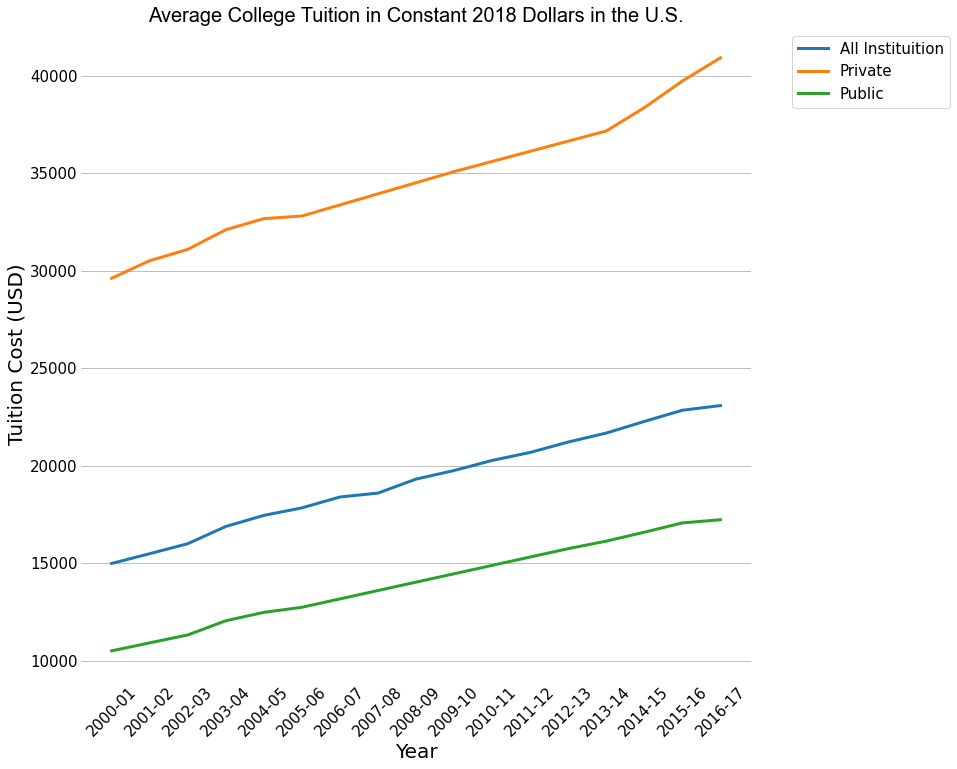

In [10]:
plt.figure(figsize=(12, 12))
ax = plt.gca()
plt.plot(all_inst.year, all_inst.tuition_cost, label = 'All Instituition', linewidth = 3)
plt.plot(private.year, private.tuition_cost, label = 'Private',linewidth = 3)
plt.plot(public.year, public.tuition_cost, label = 'Public', linewidth = 3)
plt.legend(bbox_to_anchor=(1.05,1), bbox_transform=ax.transAxes, fontsize = 15, markerfirst= True)
[ax.spines[s].set_visible(False) for s in ax.spines]
ax.tick_params(axis='y', labelsize =15)
ax.tick_params(axis='x', labelsize =15,rotation=45)
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

ax.set_facecolor('white')
ax.grid(axis='y') 
ax.set_ylabel('Tuition Cost (USD)', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)
ax.set_title('Average College Tuition in Constant 2018 Dollars in the U.S.', fontsize =20, fontname='arial')
plt.savefig('hist_trend.png', bbox_inches = 'tight')
plt.show()



In [11]:
tuition_cost.sort_values(by='out_of_state_total', ascending = False).head()

,name,state,state_code,type,degree_length,room_and_board,in_state_tuition,in_state_total,out_of_state_tuition,out_of_state_total
994,Harvey Mudd College,California,CA,Private,4 Year,18127.0,56876,75003,56876,75003
2517,University of Chicago,Illinois,IL,Private,4 Year,16350.0,58230,74580,58230,74580
586,Columbia University,New York,NY,Private,4 Year,14016.0,59985,74001,59985,74001
156,Barnard College,New York,NY,Private,4 Year,17225.0,55032,72257,55032,72257
2111,Scripps College,California,CA,Private,4 Year,16932.0,55024,71956,55024,71956


In [12]:
cols = ['out_of_state_total','in_state_total', 'type']
col_names = ['out_of_state','in_state','type']
df = tuition_cost[cols]
df.columns = col_names
df = df.loc[df['type'] != 'Other']

# since for profit schools are also private schools, we turn all for profit school into private school
df.loc[df.type == "For Profit", "type"] = "Private"
df
df1 = df.drop(['out_of_state'], axis = 1)
df1['tuition type'] = 'In State'
col_names = ['total_cost', 'type', 'tuition type']
df1.columns = col_names

df2 = df.drop(['in_state'], axis = 1)
df2['tuition type'] = 'Out of State'
df2.columns = col_names

new_df = pd.concat([df1, df2], axis=0)


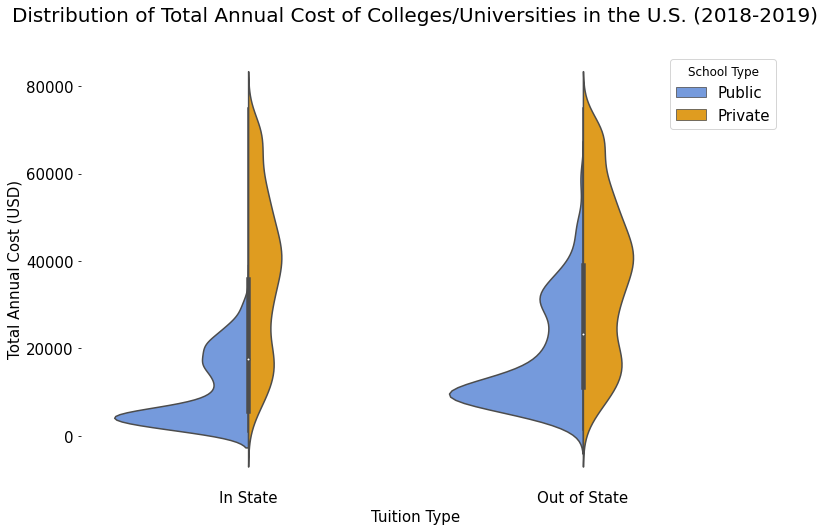

In [13]:
plt.figure(figsize = (12,8))
my_pal = {"Public": "cornflowerblue", "Private": "orange" }
sns.violinplot(data = new_df, x = 'tuition type' , y = 'total_cost', hue = 'type', palette = my_pal , split = True)
ax = plt.gca()


ax.tick_params(labelsize=15)
ax.yaxis.offsetText.set_fontsize(13)
ax.tick_params(axis='x', length=0)

[ax.spines[s].set_visible(False) for s in ax.spines]

plt.xlabel('Tuition Type',fontsize=15)
plt.ylabel('Total Annual Cost (USD)' , fontsize=15)
plt.legend(bbox_to_anchor=(1.05,1), bbox_transform=ax.transAxes, fontsize = 15, markerfirst= True, title = 'School Type', title_fontsize = 12)
plt.title('Distribution of Total Annual Cost of Colleges/Universities in the U.S. (2018-2019)', fontsize = 20, pad = 30)
plt.savefig('total_cost_dist.png', bbox_inches = 'tight')
ax.set_facecolor('white')

plt.show()

In [14]:
cols = ['in_state_total','type']
col_names = ['total_cost','type']
df = tuition_cost[cols]
df.columns = col_names
df = df.loc[df['type'] != 'Other']
df.loc[df.type == "For Profit", "type"] = "Private"
df

,total_cost,type
0,2380,Public
1,45200,Private
2,12602,Public
3,17661,Private
4,44458,Private
...,...,...
2968,5740,Public
2969,41489,Private
2970,18350,Public
2971,1400,Public


In [15]:
tuition_income = pd.read_csv('tuition_income.csv')
tuition_income

salary_potential = pd.read_csv('salary_potential.csv')
salary_potential

,rank,name,state_name,early_career_pay,mid_career_pay,make_world_better_percent,stem_percent
0,1,Auburn University,Alabama,54400,104500,51.0,31
1,2,University of Alabama in Huntsville,Alabama,57500,103900,59.0,45
2,3,The University of Alabama,Alabama,52300,97400,50.0,15
3,4,Tuskegee University,Alabama,54500,93500,61.0,30
4,5,Samford University,Alabama,48400,90500,52.0,3
...,...,...,...,...,...,...,...
930,22,Viterbo University,Wisconsin,46800,81900,62.0,3
931,23,Concordia University-Wisconsin,Wisconsin,46700,81600,61.0,9
932,24,University of Wisconsin-Parkside,Wisconsin,46000,81400,47.0,17
933,25,University of Wisconsin-River Falls,Wisconsin,47100,81300,52.0,14


In [16]:
# combine salary_potential data and tuition_cost data by school name and drop all repeated or irrelavant columns
# Then generate correlation matrix
salary_potential = pd.read_csv('salary_potential.csv')
s_p_corr = salary_potential.corr()
salary_tuition = pd.merge(salary_potential, tuition_cost , on='name')
salary_tuition  = salary_tuition.drop(['rank','name','state_name','state_code', 'type', 'degree_length', 'in_state_tuition', "out_of_state_tuition", 'room_and_board', 'state'], axis = 1)
salary_tuition.columns = ['Early Career Pay', 'Mid Career Pay', 'Self-Fulfillment Percent ', 'STEM Percent', 'In-State Cost', ' Out-of-the-State Cost']
salary_tuition_corr = salary_tuition.corr()
#mask_ut=np.triu(np.ones(salary_tuition_corr.shape)).astype(np.bool)
df_lt = salary_tuition_corr.where(np.tril(np.ones(salary_tuition_corr.shape)).astype(np.bool))



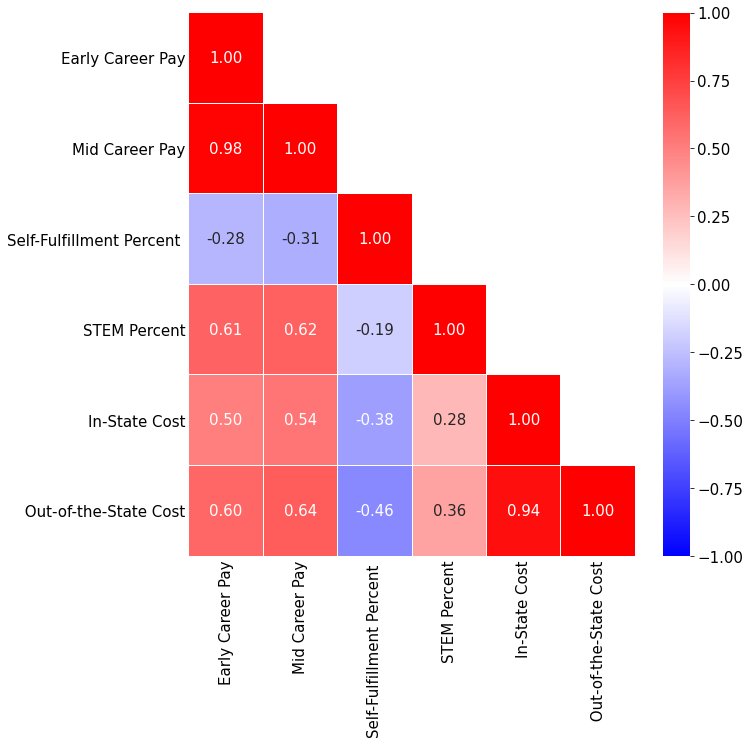

In [17]:
# Make a correlation heatmap
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_lt, cmap='bwr', 
            vmin=-1,vmax=1,annot=True, 
            fmt='.2f',annot_kws={'size':15}, 
            linewidths=.05)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
ax.set_facecolor('white')


plt.savefig('corr_heatmap', bbox_inches = 'tight')
plt.show()

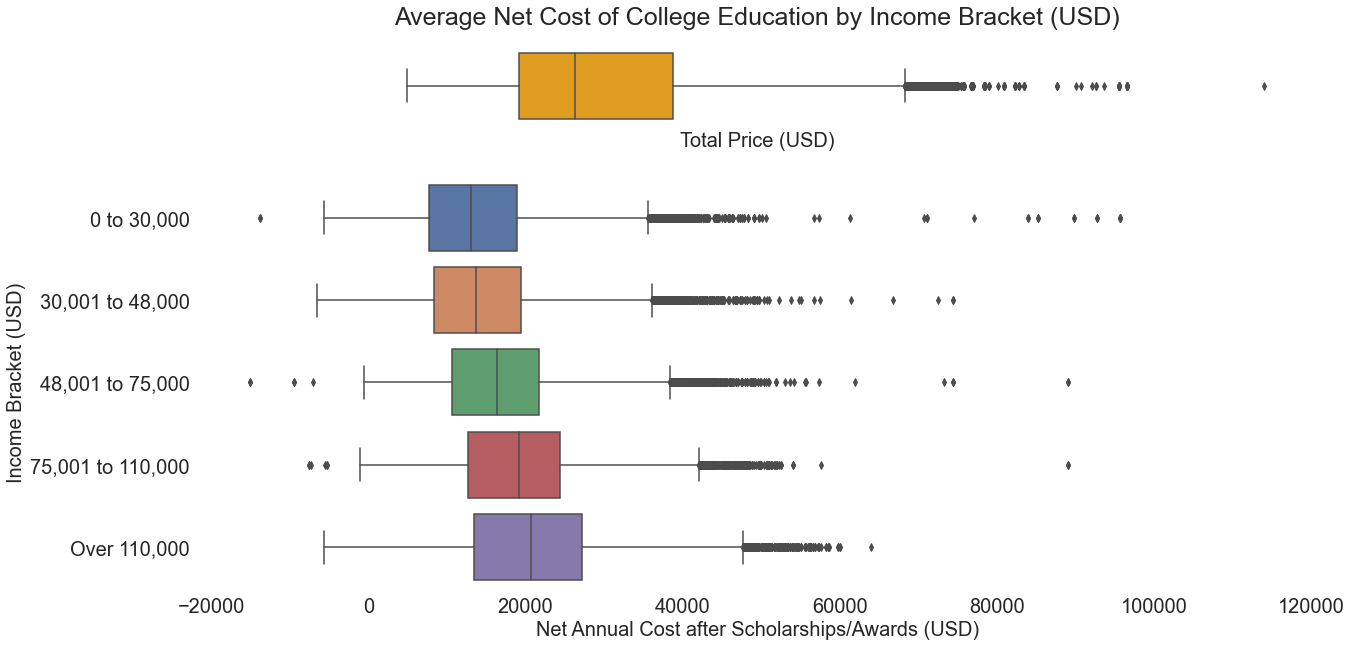

In [25]:
tuition_income.loc[tuition_income['income_lvl']=='48_001 to 75,000', ['income_lvl']] = '48,001 to 75,000'

income_bracket_1 = tuition_income[tuition_income['income_lvl'] == '0 to 30,000']
income_bracket_2 = tuition_income[tuition_income['income_lvl'] == '30,001 to 48,000']
income_bracket_3 =tuition_income[tuition_income['income_lvl'] == '48,001 to 75,000']
income_bracket_4 =tuition_income[tuition_income['income_lvl'] == '75,001 to 110,000']
income_bracket_5 =tuition_income[tuition_income['income_lvl'] == 'Over 110,000']

f, axs = plt.subplots(2,1,
                      figsize=(20,10),
                      sharex=True,
                     gridspec_kw=dict(height_ratios=[1,5]))

sns.set_theme(style="darkgrid")


sns.boxplot(data = tuition_income, x = 'total_price', orient = 'h', ax=axs[0], palette = ['orange'])
sns.boxplot(data = tuition_income, y = 'income_lvl' , x = 'net_cost', orient = 'h', ax=axs[1])

plt.xlabel('Net Annual Cost after Scholarships/Awards (USD)',fontsize=20)
plt.ylabel('Income Bracket (USD)' , fontsize=20)

axs[1].tick_params(labelsize=20)
axs[0].set_xlabel('Total Price (USD)', fontsize = 20)
axs[0].set_title('Average Net Cost of College Education by Income Bracket (USD)', fontsize = 25, pad = 20)

axs[0].set_facecolor('white')
axs[1].set_facecolor('white')
[axs[0].spines[s].set_visible(False) for s in ax.spines]
[axs[1].spines[s].set_visible(False) for s in ax.spines]

plt.savefig('income_cost_plot', bbox_inches = 'tight')

plt.show()



SyntaxError: unexpected EOF while parsing (<ipython-input-19-b338070b5839>, line 10)

[1, 2, 3, [3, 4, 5]]


143

4

2

[0, 0, 2, 0, 4, 0, 6, 0, 8, 0, 10, 0, 12, 0, 14, 0, 16]
[0, 0, 2, 0, 4, 0, 6, 0, 8, 0, 10, 0, 12, 0, 14, 0, 16]
